Sine function:

GP CBM versus STP (nu = 3) CBM (winner)

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Sine'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Sine':
    
    # True y bounds:
    operator = 1                                  # Can toggle between seeking the synthetic's minimum versus maximum
    y_global_orig = 1                             # Maximum for y = sine(x)
        
# Constraints:
    lb = 0
    ub = 2 * np.pi 

# Input array dimension(s):
    dim = 1

# 1-D input parameter bounds:
    param = {'x1_training': ('cont', [lb, ub])}
    
    x1_test = np.linspace(lb, ub, n_test)         # Define test data object
    x_test = np.column_stack((x1_test)).T         # Transposed for algebraic reasons

    def f_syn_polarity(x1_training):              # Define synthetic function
        return  operator * np.sin(x1_training)
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seed:

seed = 1


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = 1


In [10]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval. \t Proposed point \t  Current eval. \t  Best eval. \t GP CBM: StdDev. y \t GP CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.f_best = f_best
        self.f_best_min = f_best_min
        self.f_best_std = np.std(f_best)
        self.x_best = x_best
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_std)
        self.history.append(self.x_best_std)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        x_best_std = str(self.x_best_std)
        f_best_std = str(self.f_best_std)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            f_best_std = BOLD + OKGREEN + f_best_std + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_best_std, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval. \t Proposed point \t  Current eval. \t  Best eval. \t STP CBM: StdDev. y \t STP CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.f_best = f_best
        self.f_best_min = f_best_min
        self.f_best_std = np.std(f_best)
        self.x_best = x_best
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_std)
        self.history.append(self.x_best_std)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        x_best_std = str(self.x_best_std)
        f_best_std = str(self.f_best_std)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            f_best_std = BOLD + OKGREEN + f_best_std + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_best_std, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Plot Gaussian surrogate + acquisition: y = sine(x):

def plot_Gaussian(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std
    colours = ['Post', 'Random']
    a = np.array([gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-2, 2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * f_syn_polarity(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\hat{\mu}_{GP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP CBM: arg min $\mathbf{x}$')
        ###plt.legend(loc=0)
        title = 'GP CBM, optimised with approximate GP CBM gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{GP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', label='GP CBM $(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP CBM: arg min $\mathbf{x}$')
        plt.legend(loc=0)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("GP CBM $(\mathbf{x})$")
        plt.show()
        

In [13]:
### Plot Student's-t surrogate + acquisition: y = sine(x):

def plot_Student(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std # t-score, 3 DF, 95% confidence (two-tail)
    a = np.array([gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    colours = ['Post', 'Random']
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-3, 3)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * f_syn_polarity(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='STP (nu=3) posterior mean: $\hat{y} = \mu_{STP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\hat{\mu}_{STP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='STP (nu=3) CBM: arg min $\mathbf{x}$')
        ###plt.legend(loc=0)
        title = 'STP (nu=3) CBM, optimised with approximate STP (nu=3) CBM gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{STP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', ls = '--', label='STP (nu=3) CBM $(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='STP (nu=3) CBM: arg min $\mathbf{x}$')
        plt.legend(loc=4)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("STP (nu=3) CBM $(\mathbf{x})$")
        plt.show()


In [14]:
### Approximate GP CBM gradients: Sine 1st function evaluation

n_init = 3
iters = 1

np.random.seed(seed)
surrogate_approx_gp1 = GaussianProcess(cov_func, optimize=hyperOpt)

approx_gp1 = GPGO_multi(surrogate_approx_gp1, Acquisition_new(util_gp), f_syn_polarity, param)
approx_gp1.run(init_evals=n_init, max_iter=iters)


Eval. 	 Proposed point 	  Current eval. 	  Best eval. 	 GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    	    
1	 [2.62022121]	 0.49806983344840433	 0.49806983344840433	 0.05970322574636212	 2.1893352397134476


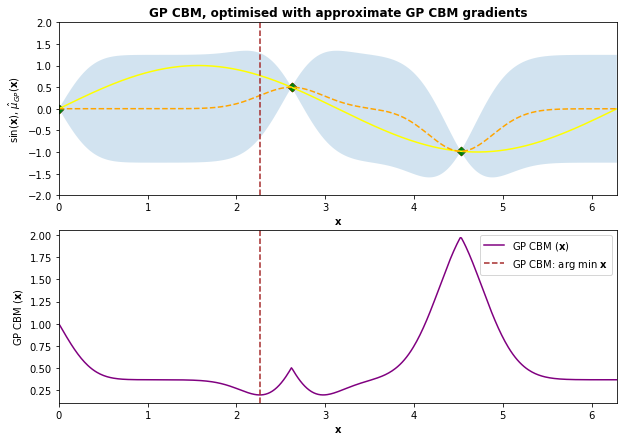

In [15]:
plot_Gaussian(approx_gp1, param, new=True)


In [16]:
### Approximate GP CBM gradients: Sine 2nd function evaluation

np.random.seed(seed)
surrogate_approx_gp2 = GaussianProcess(cov_func, optimize=hyperOpt)

approx_gp2 = GPGO_multi(surrogate_approx_gp2, Acquisition_new(util_gp), f_syn_polarity, param)
approx_gp2.run(init_evals=n_init, max_iter=iters+1)


Eval. 	 Proposed point 	  Current eval. 	  Best eval. 	 GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    	    
1	 [2.62022121]	 0.49806983344840433	 0.49806983344840433	 0.05970322574636212	 2.1893352397134476
2	 [2.26343459]	 0.7695639798045237	 0.7695639798045237	 0.06870875375949452	 1.5323605626106456


In [17]:
### Approximate STP CBM gradients: Sine 1st function evaluation

np.random.seed(seed)
surrogate_approx_stp1 = tStudentProcess(cov_func, optimize=hyperOpt, nu=df)

approx_stp1 = GPGO_multi_STP(surrogate_approx_stp1, Acquisition_new(util_stp), f_syn_polarity, param)
approx_stp1.run(init_evals=n_init, max_iter=iters)


Eval. 	 Proposed point 	  Current eval. 	  Best eval. 	 STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    	    
1	 [2.41906556]	 0.6612824492846244	 0.6612824492846244	 0.202131854027954	 2.3562314626985885


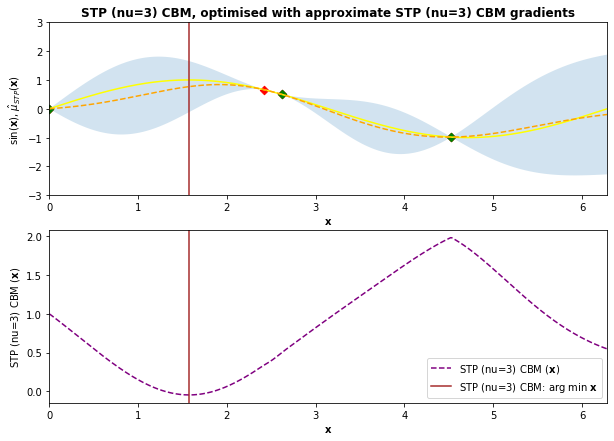

In [18]:
plot_Student(approx_stp1, param, new=True)


In [19]:
### Approximate STP CBM gradients: Sine 2nd function evaluation

np.random.seed(seed)
surrogate_approx_stp2 = tStudentProcess(cov_func, optimize=hyperOpt, nu=df)

approx_stp2 = GPGO_multi_STP(surrogate_approx_stp2, Acquisition_new(util_stp), f_syn_polarity, param)
approx_stp2.run(init_evals=n_init, max_iter=iters+1)


Eval. 	 Proposed point 	  Current eval. 	  Best eval. 	 STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    	    
1	 [2.41906556]	 0.6612824492846244	 0.6612824492846244	 0.202131854027954	 2.3562314626985885
2	 [1.57604076]	 0.9999862479874712	 0.9999862479874712	 0.23705767127248467	 1.8828578462535723
